In [ ]:
import fitz  # PyMuPDF

In [ ]:
!pip install pymupdf

ERROR: Operation cancelled by user


In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

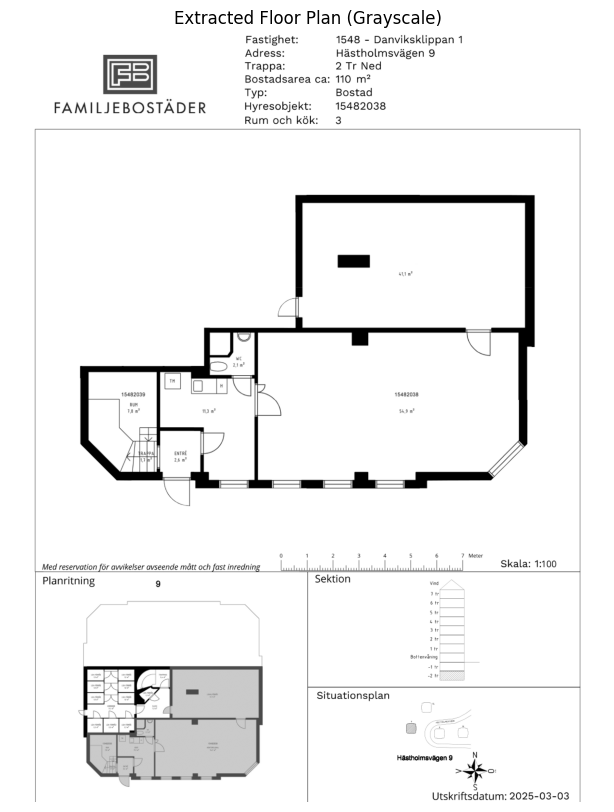

Image saved successfully at: /content/extracted_floor_plan.png


In [ ]:


# Load the PDF and extract the first page as an image
pdf_path = "/content/floor plan.pdf"
doc = fitz.open(pdf_path)
pix = doc[0].get_pixmap(matrix=fitz.Matrix(2, 2))  # Scale up for better quality

# Convert to NumPy array and then to OpenCV format
img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
if img.shape[2] == 4:  # Convert RGBA to RGB if needed
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Save the grayscale image
output_path = "/content/extracted_floor_plan.png"  # Change the path if needed
cv2.imwrite(output_path, gray)

# Display the extracted grayscale image
plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.title("Extracted Floor Plan (Grayscale)")
plt.axis("off")
plt.show()

print(f"Image saved successfully at: {output_path}")

## REMOVE TEXT

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,162 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pytesseract
from PIL import Image

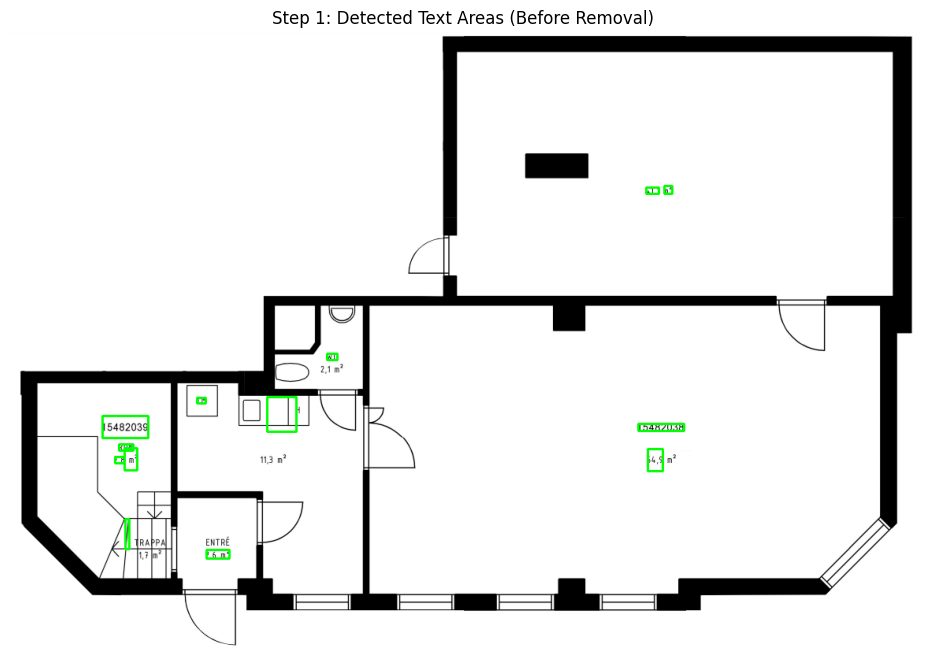

In [ ]:
# Step 1: Load the full floor plan image
img = cv2.imread("/content/extracted_floor_plan.png")

# Convert to grayscale
gray_full = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply OCR to detect text locations
ocr_data_full = pytesseract.image_to_data(gray_full, output_type=pytesseract.Output.DICT)

# Create a copy of the image to draw detected text regions
text_detection_img = img.copy()

# Step 2: Draw bounding boxes around detected text
for i in range(len(ocr_data_full["text"])):
    try:
        confidence = float(ocr_data_full["conf"][i])  # Convert confidence to float
        if confidence > 50 and ocr_data_full["text"][i].strip():  # Ensure valid text
            x, y, w, h = (ocr_data_full["left"][i], ocr_data_full["top"][i],
                          ocr_data_full["width"][i], ocr_data_full["height"][i])
            cv2.rectangle(text_detection_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box around text
    except ValueError:
        continue  # Skip invalid values

# Display the detected text areas before removal
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(text_detection_img, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
plt.title("Step 1: Detected Text Areas (Before Removal)")
plt.axis("off")
plt.show()


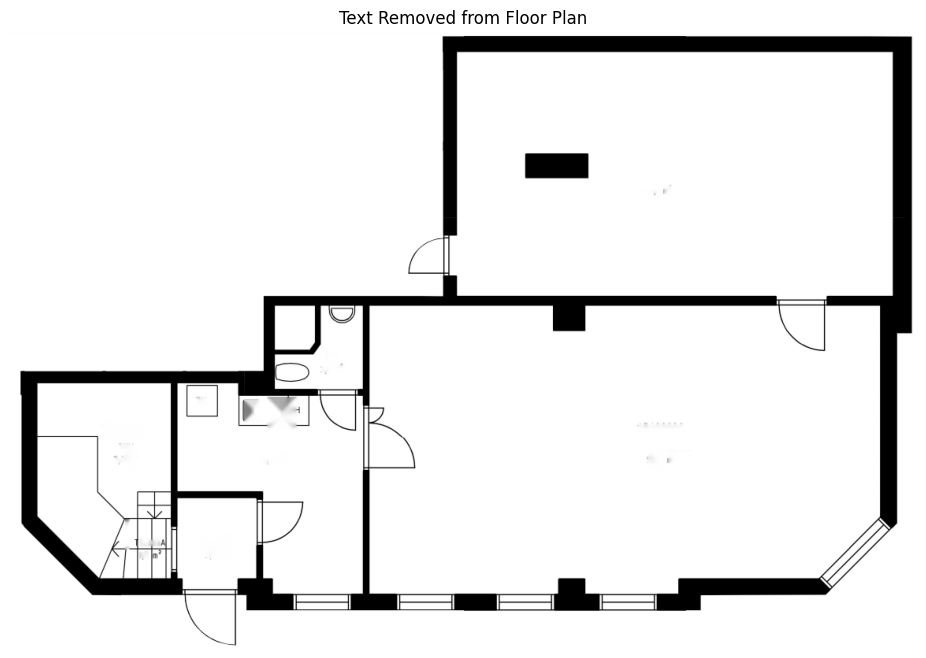

'/content/floor_plan_no_text.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

# Load the floor plan image
image_path = "/content/extracted_floor_plan.png"
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply OCR to detect text locations
ocr_data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

# Create a mask for text areas
mask = np.zeros_like(gray)

for i in range(len(ocr_data["text"])):
    try:
        confidence = float(ocr_data["conf"][i])  # Convert confidence to float
        if confidence > 30 and ocr_data["text"][i].strip():  # Ensure valid text
            x, y, w, h = (ocr_data["left"][i], ocr_data["top"][i],
                          ocr_data["width"][i], ocr_data["height"][i])
            cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)  # White box on mask
    except ValueError:
        continue  # Skip invalid values

# Inpaint the image to remove text
inpainted_img = cv2.inpaint(img, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(inpainted_img, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
plt.title("Text Removed from Floor Plan")
plt.axis("off")
plt.show()

# Save the processed image
output_path = "/content/floor_plan_no_text.png"
cv2.imwrite(output_path, inpainted_img)

# Provide download link
output_path


# TRIALS TO DETECT WALLS AND WINDOWS

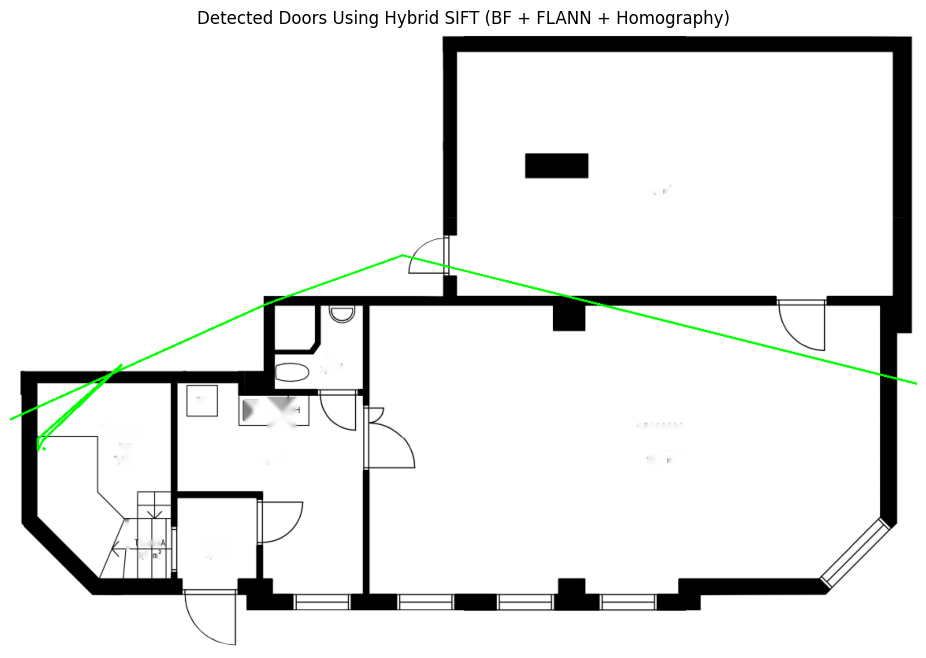

'/mnt/data/detected_doors_sift_updated.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load floor plan
floor_plan_path = "/content/floor_plan_no_text.png"
floor_plan = cv2.imread(floor_plan_path, cv2.IMREAD_GRAYSCALE)

# Load door templates
template_paths = ["/content/door.png", "/content/door2.png", "/content/door3.png"]
templates = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in template_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for the floor plan
keypoints_plan, descriptors_plan = sift.detectAndCompute(floor_plan, None)

# Convert floor plan to color for visualization
detection_result = cv2.cvtColor(floor_plan, cv2.COLOR_GRAY2BGR)

# Initialize FLANN-based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Iterate through each door template
for template in templates:
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

    if descriptors_template is None or descriptors_plan is None:
        continue  # Skip if no features are found

    # Match descriptors using FLANN matcher
    matches = flann.knnMatch(descriptors_template, descriptors_plan, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]  # Increased from 0.75 to 0.85

    if len(good_matches) > 10:  # Ensure enough matches exist
        src_pts = np.float32([keypoints_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_plan[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography to locate doors
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if M is not None:
            h, w = template.shape
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
            transformed_corners = cv2.perspectiveTransform(corners, M)

            # Draw bounding box around detected doors
            transformed_corners = np.int32(transformed_corners)
            cv2.polylines(detection_result, [transformed_corners], True, (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(detection_result, cv2.COLOR_BGR2RGB))
plt.title("Detected Doors Using Hybrid SIFT (BF + FLANN + Homography)")
plt.axis("off")
plt.show()

# Save the detected image
output_path_sift_updated = "/mnt/data/detected_doors_sift_updated.png"
cv2.imwrite(output_path_sift_updated, detection_result)

# Provide download link
output_path_sift_updated


In [ ]:
'''
        # Compute bounding box based on matched keypoints
        x_min, y_min = np.min(dst_pts, axis=0)[0]
        x_max, y_max = np.max(dst_pts, axis=0)[0]

        # Ensure valid bounding box size (filter out incorrect detections)
        if (x_max - x_min) > 3 and (y_max - y_min) > 3:
            cv2.rectangle(detection_result, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)'''

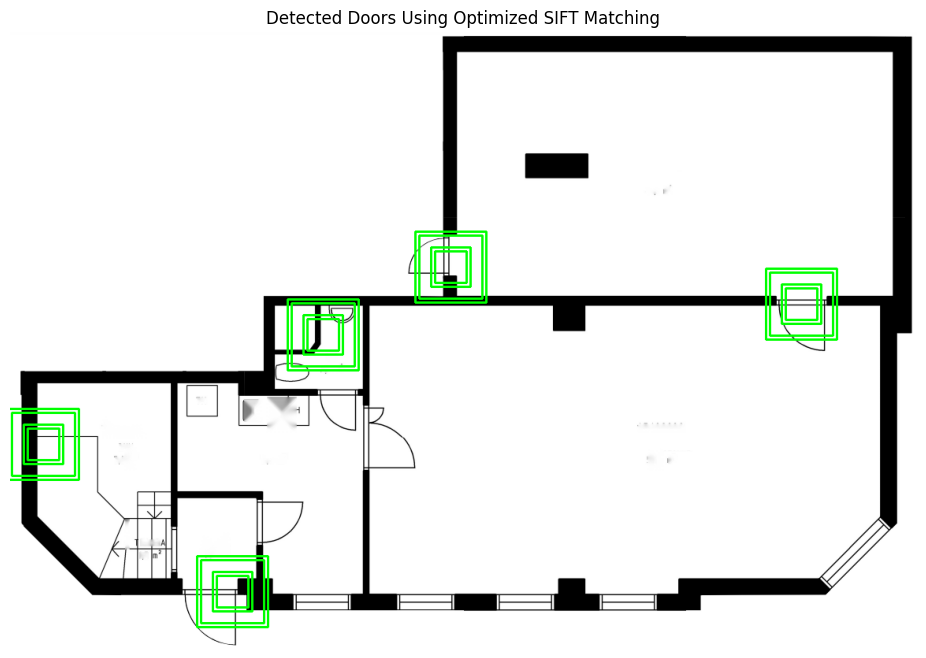

'/mnt/data/detected_doors_sift_optimized.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load floor plan
floor_plan_path = "/content/floor_plan_no_text.png"
floor_plan = cv2.imread(floor_plan_path, cv2.IMREAD_GRAYSCALE)

# Load door templates
template_paths = ["/content/door.png", "/content/door2.png", "/content/door3.png"]
templates = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in template_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for the floor plan
keypoints_plan, descriptors_plan = sift.detectAndCompute(floor_plan, None)

# Convert floor plan to color for visualization
detection_result = cv2.cvtColor(floor_plan, cv2.COLOR_GRAY2BGR)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher()

# Iterate through each door template
for template in templates:
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

    if descriptors_template is None or descriptors_plan is None:
        continue  # Skip if no features are found

    # Match descriptors using BFMatcher
    matches = bf.knnMatch(descriptors_template, descriptors_plan, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]  # Increased from 0.75 to 0.85

    if len(good_matches) > 10:  # Ensure enough matches exist
        src_pts = np.float32([keypoints_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_plan[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)







        # Draw refined bounding boxes around each detected door
        for center in clustered_pts:
            x, y = int(center[0]), int(center[1])
            box_size = 45  # Estimated door size (adjustable)
            x_min, y_min = x - box_size, y - box_size
            x_max, y_max = x + box_size, y + box_size

            # Ensure valid box size
            if 10 < (x_max - x_min) < 100 and 10 < (y_max - y_min) < 100:
                all_detected_boxes.append(((x_min, y_min), (x_max, y_max)))

# Draw all refined bounding boxes
for (x_min, y_min), (x_max, y_max) in all_detected_boxes:
    cv2.rectangle(detection_result, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(detection_result, cv2.COLOR_BGR2RGB))
plt.title("Detected Doors Using Optimized SIFT Matching")
plt.axis("off")
plt.show()


# Provide download link
output_path_sift_optimized


In [ ]:

# Save the detected image
output_path_sift_optimized = "/mnt/data/detected_doors_sift_optimized.png"
cv2.imwrite(output_path_sift_optimized, detection_result)


In [ ]:
, "/content/door2.png", "/content/door3.png"

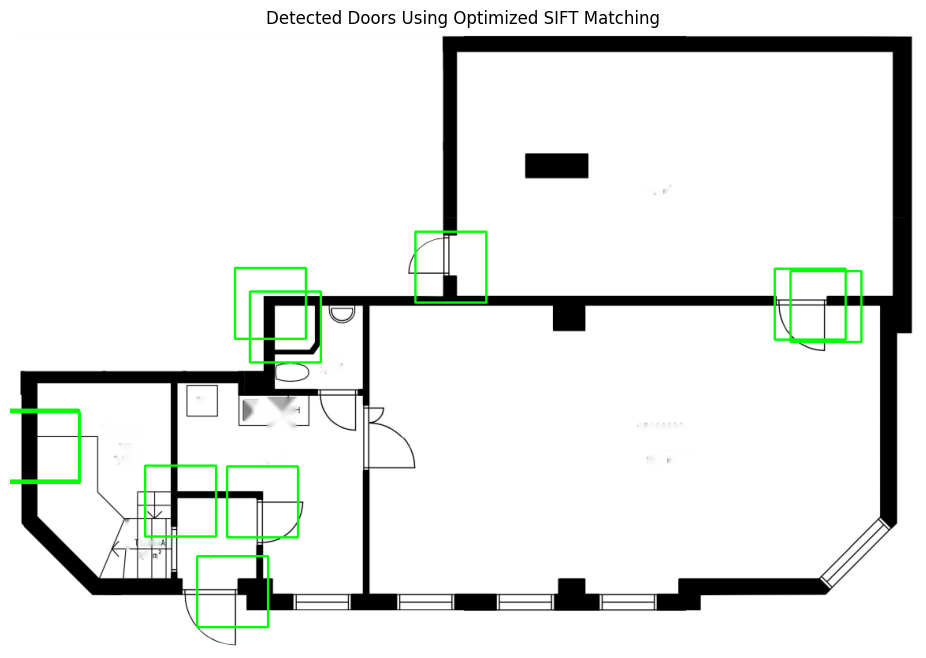

'/mnt/data/detected_doors_sift_optimized.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load floor plan
floor_plan_path = "/content/floor_plan_no_text.png"
floor_plan = cv2.imread(floor_plan_path, cv2.IMREAD_GRAYSCALE)

# Load door templates
template_paths = ["/content/door2.png", "/content/door3.png"]
templates = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in template_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for the floor plan
keypoints_plan, descriptors_plan = sift.detectAndCompute(floor_plan, None)

# Convert floor plan to color for visualization
detection_result = cv2.cvtColor(floor_plan, cv2.COLOR_GRAY2BGR)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher()

# Store detected bounding boxes
all_detected_boxes = []

# Iterate through each door template
for template in templates:
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

    if descriptors_template is None or descriptors_plan is None:
        continue  # Skip if no features are found

    # Match descriptors using BFMatcher
    matches = bf.knnMatch(descriptors_template, descriptors_plan, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]

    if len(good_matches) > 10:  # Ensure enough matches exist
        dst_pts = np.float32([keypoints_plan[m.trainIdx].pt for m in good_matches])  # Extract matched keypoints

        # Apply K-Means clustering to separate individual doors
        num_clusters = min(len(dst_pts), 5)  # Avoid too many clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(dst_pts)
        clustered_pts = kmeans.cluster_centers_  # Get cluster centers

        # Draw refined bounding boxes around each detected door
        for center in clustered_pts:
            x, y = int(center[0]), int(center[1])
            box_size = 45  # Estimated door size (adjustable)
            x_min, y_min = x - box_size, y - box_size
            x_max, y_max = x + box_size, y + box_size

            # Ensure valid box size
            if 10 < (x_max - x_min) < 100 and 10 < (y_max - y_min) < 100:
                all_detected_boxes.append(((x_min, y_min), (x_max, y_max)))

# Draw all refined bounding boxes
for (x_min, y_min), (x_max, y_max) in all_detected_boxes:
    cv2.rectangle(detection_result, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(detection_result, cv2.COLOR_BGR2RGB))
plt.title("Detected Doors Using Optimized SIFT Matching")
plt.axis("off")
plt.show()

# Save the detected image
output_path_sift_optimized = "/mnt/data/detected_doors_sift_optimized.png"
cv2.imwrite(output_path_sift_optimized, detection_result)

# Provide download link
output_path_sift_optimized


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load floor plan
floor_plan_path = "/content/floor_plan_no_text.png"
floor_plan = cv2.imread(floor_plan_path, cv2.IMREAD_GRAYSCALE)

# Load door templates
template_paths = ["/content/door.png", "/content/door2.png", "/content/door3.png"]
templates = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in template_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for the floor plan
keypoints_plan, descriptors_plan = sift.detectAndCompute(floor_plan, None)

# Convert floor plan to color for visualization
detection_result = cv2.cvtColor(floor_plan, cv2.COLOR_GRAY2BGR)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher()

all_detected_boxes = []  # Store all detected bounding boxes

# Iterate through each door template
for template in templates:
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

    if descriptors_template is None or descriptors_plan is None:
        continue  # Skip if no features are found

    # Match descriptors using BFMatcher
    matches = bf.knnMatch(descriptors_template, descriptors_plan, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]

    if len(good_matches) > 10:  # Ensure enough matches exist
        dst_pts = np.float32([keypoints_plan[m.trainIdx].pt for m in good_matches])  # Extract matched keypoints

        # Apply K-Means clustering to separate individual doors
        # Apply K-Means clustering to separate individual doors
        num_clusters = min(max(2, len(dst_pts) // 3), 5)  # Dynamic clustering based on available keypoints


        if num_clusters > 1:  # Ensure at least 2 clusters exist
            kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(dst_pts)
            clustered_pts = kmeans.cluster_centers_  # Get cluster centers
        else:
            clustered_pts = dst_pts  # If too few points, use them directly


        # Draw refined bounding boxes around each detected door
        for center in clustered_pts:
            x, y = int(center[0]), int(center[1])
            box_size = 45  # Estimated door size (adjustable)
            x_min, y_min = x - box_size, y - box_size
            x_max, y_max = x + box_size, y + box_size

            # Ensure valid box size and filter using aspect ratio **(NEW FILTER ADDED HERE)**
            aspect_ratio = (x_max - x_min) / (y_max - y_min)
            if 10 < (x_max - x_min) < 100 and 10 < (y_max - y_min) < 100 and 0.5 < aspect_ratio < 2.0:
                all_detected_boxes.append((x_min, y_min, x_max, y_max))  # Changed format for NMS

# **Apply Non-Maximum Suppression (NMS) to remove duplicate boxes**
def non_max_suppression(boxes, overlapThresh=0.3):
    if len(boxes) == 0:
        return []
        if len(idxs) == 0:
            break  # Avoid infinite loop


    boxes = np.array(boxes)
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    picked_boxes = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        picked_boxes.append(boxes[i])

        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / areas[idxs[:-1]]
        idxs = np.delete(idxs, np.where(overlap > overlapThresh)[0])

    return picked_boxes

# Apply NMS to refine detected boxes **(NEW STEP ADDED HERE)**
filtered_boxes = non_max_suppression(all_detected_boxes)

# Draw all refined bounding boxes
for (x_min, y_min, x_max, y_max) in filtered_boxes:
    cv2.rectangle(detection_result, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(detection_result, cv2.COLOR_BGR2RGB))
plt.title("Detected Doors with NMS & Aspect Ratio Filtering")
plt.axis("off")
plt.show()

# Save the detected image
output_path_sift_refined = "/mnt/data/detected_doors_sift_nms.png"
cv2.imwrite(output_path_sift_refined, detection_result)

# Provide download link
output_path_sift_refined


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


SyntaxError: 'break' outside loop (<ipython-input-63-14c90b094525>, line 73)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


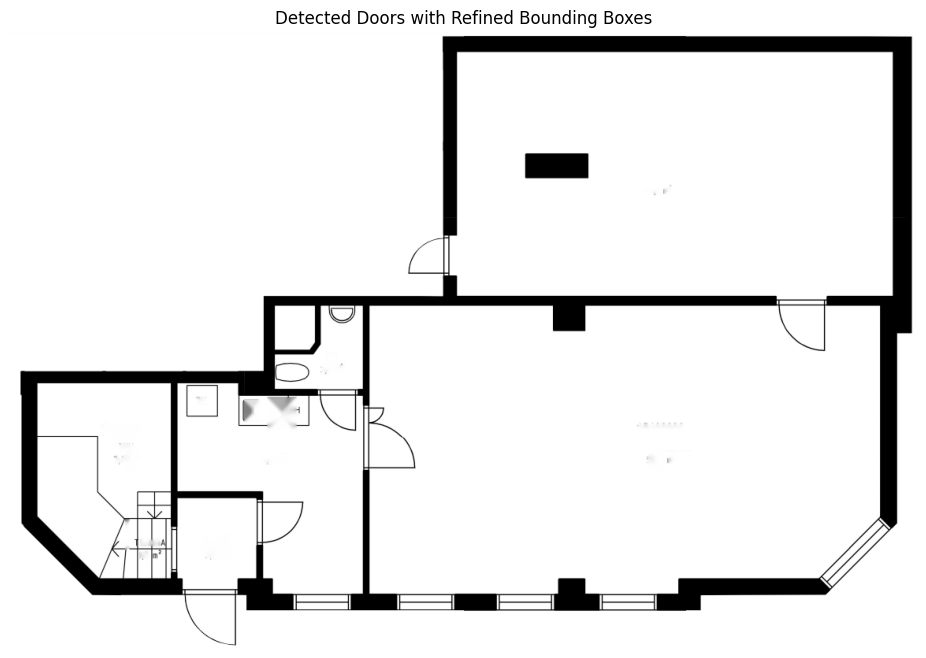

'/mnt/data/detected_doors_sift_refined.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load floor plan
floor_plan_path = "/content/floor_plan_no_text.png"
floor_plan = cv2.imread(floor_plan_path, cv2.IMREAD_GRAYSCALE)

# Load door templates
template_paths = ["/content/door.png", "/content/door2.png", "/content/door3.png"]
templates = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in template_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for the floor plan
keypoints_plan, descriptors_plan = sift.detectAndCompute(floor_plan, None)

# Convert floor plan to color for visualization
detection_result = cv2.cvtColor(floor_plan, cv2.COLOR_GRAY2BGR)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher()

all_detected_boxes = []  # Store all detected bounding boxes

# Iterate through each door template
for template in templates:
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

    if descriptors_template is None or descriptors_plan is None:
        continue  # Skip if no features are found

    # Match descriptors using BFMatcher
    matches = bf.knnMatch(descriptors_template, descriptors_plan, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.9 * n.distance]  # Increased from 0.75 to 0.85

    if len(good_matches) > 10:  # Ensure enough matches exist
        dst_pts = np.float32([keypoints_plan[m.trainIdx].pt for m in good_matches])  # Extract matched keypoints

        # Apply K-Means clustering to separate individual doors
        num_clusters = min(len(dst_pts), 5)  # Avoid too many clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(dst_pts)
        clustered_pts = kmeans.cluster_centers_  # Get cluster centers

        # Draw refined bounding boxes around each detected door
        for center in clustered_pts:
            x, y = int(center[0]), int(center[1])
            box_size = 50  # Estimated door size (adjustable)
            x_min, y_min = x - box_size, y - box_size
            x_max, y_max = x + box_size, y + box_size

            # Ensure valid box size
            if 10 < (x_max - x_min) < 100 and 10 < (y_max - y_min) < 100:
                all_detected_boxes.append(((x_min, y_min), (x_max, y_max)))

# Draw all refined bounding boxes
for (x_min, y_min), (x_max, y_max) in all_detected_boxes:
    cv2.rectangle(detection_result, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(detection_result, cv2.COLOR_BGR2RGB))
plt.title("Detected Doors with Refined Bounding Boxes")
plt.axis("off")
plt.show()

# Save the detected image
output_path_sift_refined = "/mnt/data/detected_doors_sift_refined.png"
cv2.imwrite(output_path_sift_refined, detection_result)

# Provide download link
output_path_sift_refined


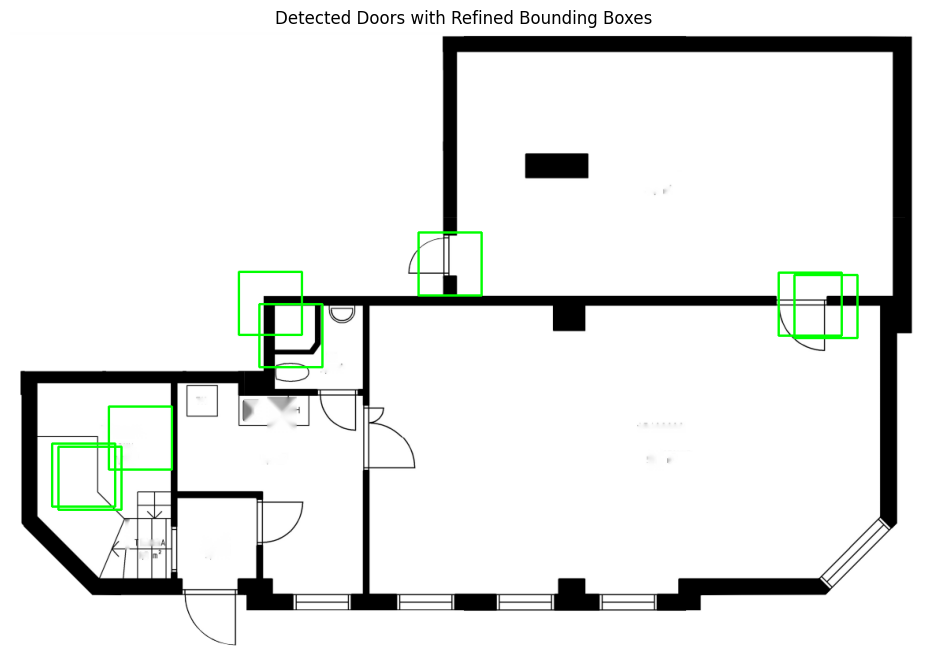

'/mnt/data/detected_doors_sift_refined.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load floor plan
floor_plan_path = "/content/floor_plan_no_text.png"
floor_plan = cv2.imread(floor_plan_path, cv2.IMREAD_GRAYSCALE)

# Load door templates
template_paths = ["/content/door.png", "/content/door2.png", "/content/door3.png"]
templates = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in template_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute keypoints and descriptors for the floor plan
keypoints_plan, descriptors_plan = sift.detectAndCompute(floor_plan, None)

# Convert floor plan to color for visualization
detection_result = cv2.cvtColor(floor_plan, cv2.COLOR_GRAY2BGR)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher()

all_detected_boxes = []  # Store all detected bounding boxes

# Iterate through each door template
for template in templates:
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

    if descriptors_template is None or descriptors_plan is None:
        continue  # Skip if no features are found

    # Match descriptors using BFMatcher
    matches = bf.knnMatch(descriptors_template, descriptors_plan, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]  # Increased from 0.75 to 0.9

    if len(good_matches) > 10:  # Ensure enough matches exist
        dst_pts = np.float32([keypoints_plan[m.trainIdx].pt for m in good_matches])  # Extract matched keypoints

        # **Fix for K-Means Warning: Dynamically adjust clusters**
        unique_pts = np.unique(dst_pts, axis=0)  # Remove duplicate keypoints
        num_clusters = min(max(2, len(unique_pts) // 3), len(unique_pts))  # Ensure valid cluster count

        if num_clusters > 1:  # Only cluster if there are enough unique points
            kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(unique_pts)
            clustered_pts = kmeans.cluster_centers_
        else:
            clustered_pts = unique_pts  # Use raw points if too few clusters exist

        # Draw refined bounding boxes around each detected door
        for center in clustered_pts:
            x, y = int(center[0]), int(center[1])
            box_size = 40  # Estimated door size (adjustable)
            x_min, y_min = x - box_size, y - box_size
            x_max, y_max = x + box_size, y + box_size

            # Ensure valid box size
            if 10 < (x_max - x_min) < 100 and 10 < (y_max - y_min) < 100:
                all_detected_boxes.append(((x_min, y_min), (x_max, y_max)))

# Draw all refined bounding boxes
for (x_min, y_min), (x_max, y_max) in all_detected_boxes:
    cv2.rectangle(detection_result, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(detection_result, cv2.COLOR_BGR2RGB))
plt.title("Detected Doors with Refined Bounding Boxes")
plt.axis("off")
plt.show()

# Save the detected image
output_path_sift_refined = "/mnt/data/detected_doors_sift_refined.png"
cv2.imwrite(output_path_sift_refined, detection_result)

# Provide download link
output_path_sift_refined


# DETECT WITH ROBOFLOW

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...
{
  "x": 343,
  "y": 622,
  "width": 57,
  "height": 57,
  "confidence": 0.8871698975563049,
  "class": "door",
  "class_id": 0,
  "detection_id": "d4776ff8-6f7f-4f96-afb5-c3cc5e61c14f",
  "image_path": "/content/floor_plan_no_text.png",
  "prediction_type": "ObjectDetectionModel"
}

{
  "x": 532,
  "y": 284,
  "width": 53,
  "height": 50,
  "confidence": 0.8624268770217896,
  "class": "door",
  "class_id": 0,
  "detection_id": "621dadef-62c9-40a6-a24e-84d9775a2122",
  "image_path": "/content/floor_plan_no_text.png",
  "prediction_type": "ObjectDetectionModel"
}

{
  "x": 255,
  "y": 744,
  "width": 68,
  "height": 68,
  "confidence": 0.8549412488937378,
  "class": "door",
  "class_id": 0,
  "detection_id": "5b6b28f6-d0d8-4a51-9f0a-58aa1fc5862d",
  "image_path": "/content/floor_plan_no_text.png",
  "prediction_type": "ObjectDetectionModel"
}

{
  "x": 416,
  "y": 480,
  "width": 48,
  "height": 51,
  "confidence": 0.852169990539

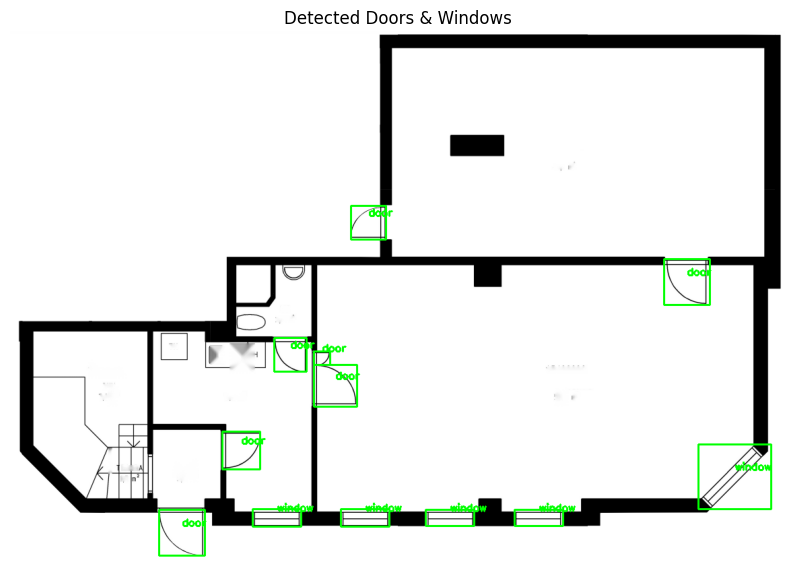

In [ ]:
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt

# Initialize the Roboflow API Client
rf = Roboflow(api_key="yXCwbPygKyQaG8p3ZzRN") # Replace with your actual API key
project = rf.workspace().project("doors-windows-iliyz")
model = project.version(1).model

# Load the image
image_path = "/content/floor_plan_no_text.png"  # Replace with the path to your floor plan
result = model.predict(image_path)

# Print detected objects
print(result)

# Load the image using OpenCV
img = cv2.imread(image_path)

# If predictions exist, draw bounding boxes
if result.predictions:
    for prediction in result.predictions:
        x, y, w, h = int(prediction['x']), int(prediction['y']), int(prediction['width']), int(prediction['height'])
        label = prediction['class']

        # Draw bounding boxes
        cv2.rectangle(img, (x - w//2, y - h//2), (x + w//2, y + h//2), (0, 255, 0), 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with detections
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Detected Doors & Windows")
plt.axis("off")
plt.show()


loading Roboflow workspace...
loading Roboflow project...


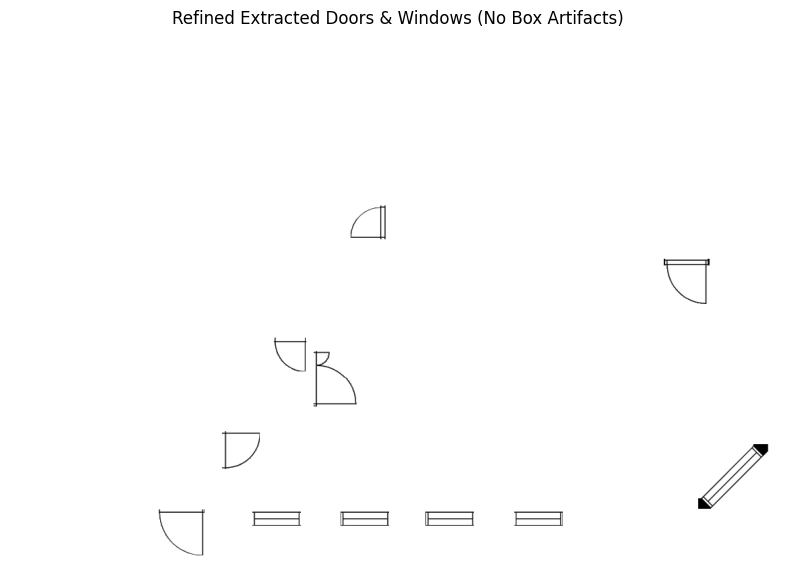

True

In [ ]:
from roboflow import Roboflow
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Roboflow API Client
rf = Roboflow(api_key="yXCwbPygKyQaG8p3ZzRN")  # Replace with your actual API key
project = rf.workspace().project("doors-windows-iliyz")
model = project.version(1).model

# Load the image
image_path = "/content/floor_plan_no_text.png"  # Use the uploaded file
image = cv2.imread(image_path)

# Predict using the model
result = model.predict(image_path)

# Create an empty mask (black)
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Process each detected object
if result.predictions:
    for prediction in result.predictions:
        x, y, w, h = int(prediction['x']), int(prediction['y']), int(prediction['width']), int(prediction['height'])

        # Extract only the detected area
        detected_region = image[y - h//2 : y + h//2, x - w//2 : x + w//2].copy()

        # Convert the detected region to grayscale
        gray_region = cv2.cvtColor(detected_region, cv2.COLOR_BGR2GRAY)

        # Threshold to get binary mask (removing background noise)
        _, region_mask = cv2.threshold(gray_region, 200, 255, cv2.THRESH_BINARY_INV)

        # Find contours of the actual objects inside the detected area
        contours, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the exact contours on the main mask (removing bounding box influence)
        for cnt in contours:
            cnt[:, 0, 0] += x - w//2  # Adjust x-coordinates
            cnt[:, 0, 1] += y - h//2  # Adjust y-coordinates
            cv2.drawContours(mask, [cnt], -1, (255), thickness=cv2.FILLED)

# Extract only the detected doors/windows using the refined mask
extracted_layer = cv2.bitwise_and(image, image, mask=mask)

# Convert black background to transparent (removing unnecessary parts)
b, g, r = cv2.split(extracted_layer)
alpha = mask  # Use mask as the alpha channel
extracted_layer_rgba = cv2.merge((b, g, r, alpha))

# Save or display the refined extracted layer
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(extracted_layer_rgba, cv2.COLOR_BGRA2RGBA))  # Convert for correct display
plt.title("Refined Extracted Doors & Windows (No Box Artifacts)")
plt.axis("off")
plt.show()

# Save the extracted layer
cv2.imwrite("/content/extracted_doors_windows.png", extracted_layer_rgba)


# EXTRACT WALLS

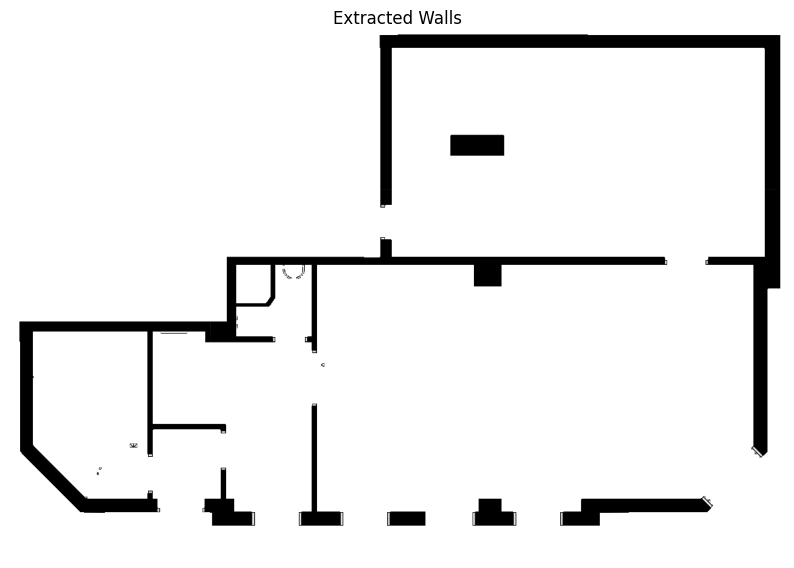

In [ ]:
# Load the image
image_path = "/content/floor_plan_no_text.png"
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Adaptive Thresholding (better for uneven lighting)
thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 4
)

# Remove small elements (text, noise) using Morphological Opening
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours (extract walls)
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank mask for detected walls
wall_mask = np.zeros_like(gray)

# Draw only large contours (removes small text and artifacts)
for contour in contours:
    if cv2.contourArea(contour) > 500:
        cv2.drawContours(wall_mask, [contour], -1, 255, thickness=cv2.FILLED)

# **Invert the walls layer (white walls, black background)**
inverted_walls = cv2.bitwise_not(wall_mask)

# Convert black background to transparent for walls
b, g, r = cv2.split(img)
alpha = cv2.bitwise_not(wall_mask)  # Use the inverted mask as transparency
walls_rgba = cv2.merge((b, g, r, alpha))
# Display the extracted walls
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(extracted_walls_rgba, cv2.COLOR_BGRA2RGBA))  # Convert for correct display
plt.title("Extracted Walls")
plt.axis("off")
plt.show()


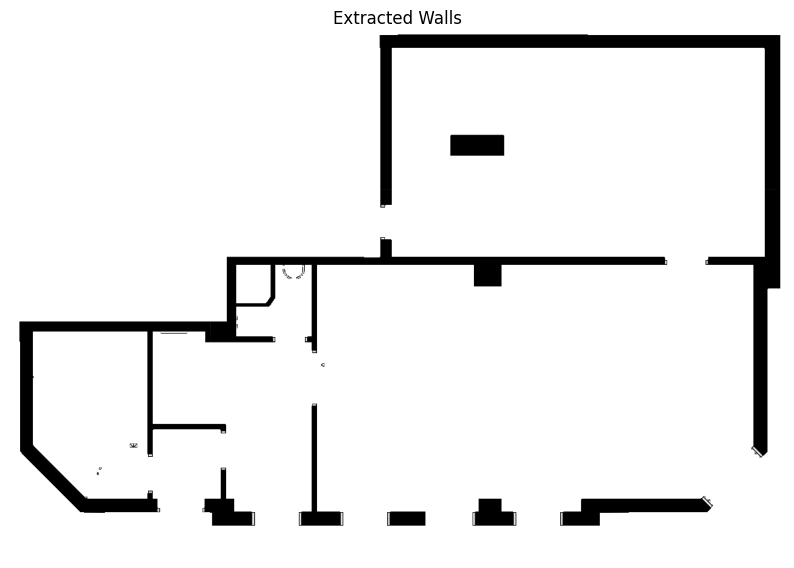

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the floor plan image
image_path = "/content/floor_plan_no_text.png"  # Use your uploaded image
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to extract walls
_, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Invert to make walls white

# Remove small noise using morphological operations
kernel = np.ones((3,3), np.uint8)  # Define kernel size for noise reduction
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)  # Fill gaps
binary_cleaned = cv2.morphologyEx(binary_cleaned, cv2.MORPH_OPEN, kernel, iterations=1)  # Remove small noise

# Create a mask for extraction
mask = binary_cleaned

# Extract only the walls from the original image
extracted_walls = cv2.bitwise_and(image, image, mask=mask)

# Convert black background to transparent
b, g, r = cv2.split(extracted_walls)
alpha = mask  # Use the binary mask as alpha
extracted_walls_rgba = cv2.merge((b, g, r, alpha))

# Display the extracted walls
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(extracted_walls_rgba, cv2.COLOR_BGRA2RGBA))  # Convert for correct display
plt.title("Extracted Walls")
plt.axis("off")
plt.show()

# Save the extracted walls as a transparent PNG
cv2.imwrite("/content/extracted_walls.png", extracted_walls_rgba)


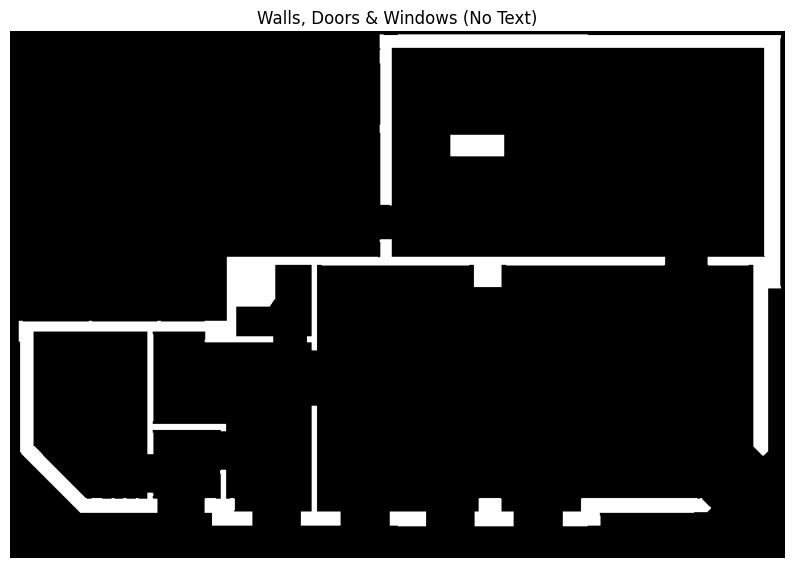

True

In [ ]:
# Load the new uploaded image
image_path = "/content/floor_plan_no_text.png"
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Adaptive Thresholding (better for uneven lighting)
thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 4
)

# Remove small elements (text) using Morphological Opening
kernel = np.ones((3, 3), np.uint8)  # Small kernel size for removing thin lines
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours (extract walls, doors, and windows)
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank mask to draw the detected elements
contour_mask = np.zeros_like(gray)

# Draw only large contours (removes small text and artifacts)
for contour in contours:
    if cv2.contourArea(contour) > 500:  # Ignore small text-like areas
        cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)

# Display the final output (walls, doors, and windows without text)
plt.figure(figsize=(10, 10))
plt.imshow(contour_mask, cmap='gray')
plt.title("Walls, Doors & Windows (No Text)")
plt.axis("off")
plt.show()
# Save the inverted image
cv2.imwrite("/content/walls.png", contour_mask)


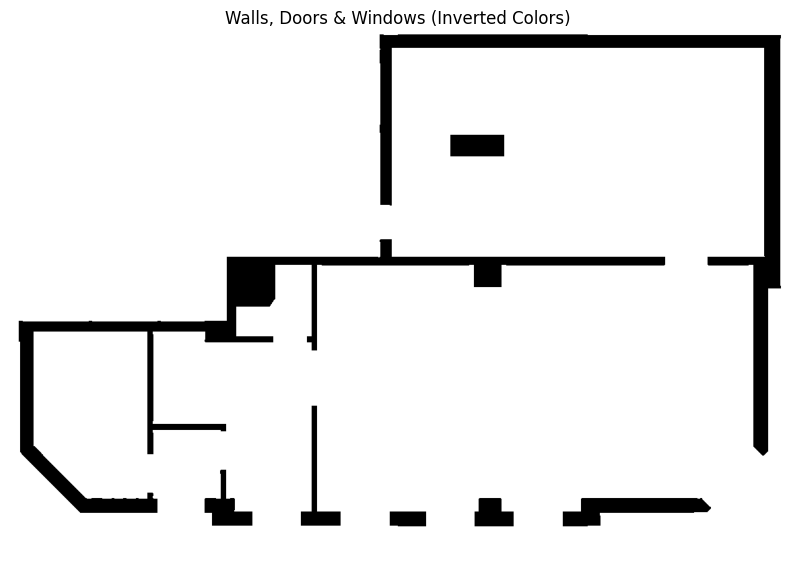

In [ ]:
# Invert the colors of the contour mask
inverted_mask = cv2.bitwise_not(contour_mask)

# Display the inverted output
plt.figure(figsize=(10, 10))
plt.imshow(inverted_mask, cmap='gray')
plt.title("Walls, Doors & Windows (Inverted Colors)")
plt.axis("off")
plt.show()



COMBINE WALLS DOORS WINDOWS

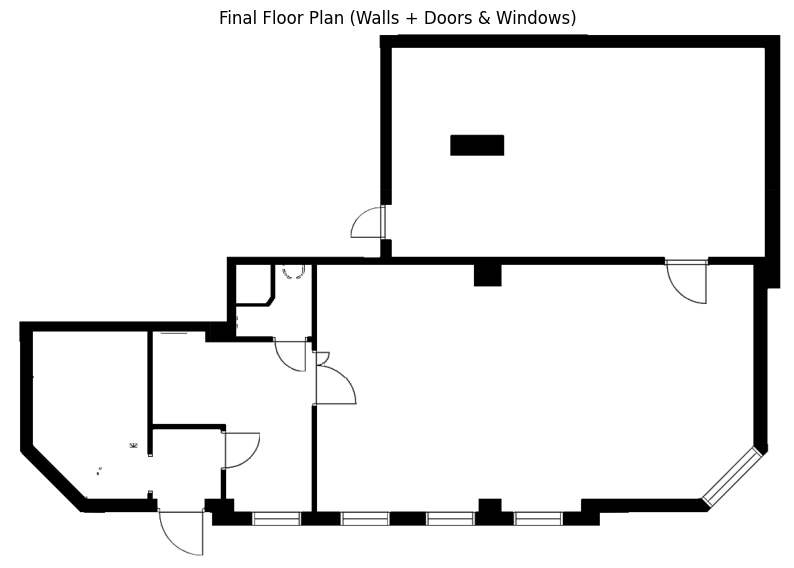

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the walls layer (already inverted)
walls_path = "/content/extracted_walls.png"  # Path to your walls-only image
walls = cv2.imread(walls_path, cv2.IMREAD_UNCHANGED)  # Load with transparency

# Load the doors & windows layer
doors_windows_path = "/content/extracted_doors_windows.png"  # Path to doors/windows image
doors_windows = cv2.imread(doors_windows_path, cv2.IMREAD_UNCHANGED)  # Load with transparency

# Ensure both images have the same size
if walls.shape[:2] != doors_windows.shape[:2]:
    doors_windows = cv2.resize(doors_windows, (walls.shape[1], walls.shape[0]))

# Convert walls to RGBA if needed (add transparency channel)
if walls.shape[2] == 3:  # If walls have no alpha channel
    b, g, r = cv2.split(walls)
    alpha = np.ones(b.shape, dtype=np.uint8) * 255  # Fully opaque
    walls = cv2.merge((b, g, r, alpha))

# Convert doors & windows to RGBA if needed
if doors_windows.shape[2] == 3:  # If doors/windows have no alpha channel
    b, g, r = cv2.split(doors_windows)
    alpha = np.ones(b.shape, dtype=np.uint8) * 255  # Fully opaque
    doors_windows = cv2.merge((b, g, r, alpha))

# Blend the images using alpha compositing
final_blend = cv2.addWeighted(walls, 1.0, doors_windows, 1.0, 0)

# Display the final result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(final_blend, cv2.COLOR_BGRA2RGBA))  # Convert for correct display
plt.title("Final Floor Plan (Walls + Doors & Windows)")
plt.axis("off")
plt.show()

# Save the final blended image
cv2.imwrite("/content/final_floor_plan.png", final_blend)


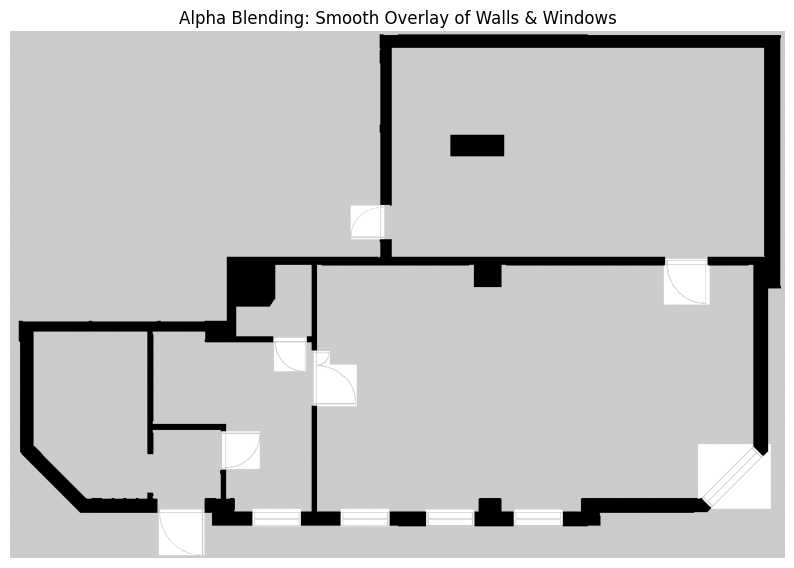

In [ ]:
# Set alpha (transparency level)
alpha = 0.8  # Adjust between 0.5 - 0.8 for best effect

# Blend both masks (smooth overlay)
blended_mask = cv2.addWeighted(inverted_mask, alpha, roboflow_mask_resized, 1 - alpha, 0)

# Display the final blended mask
plt.figure(figsize=(10, 10))
plt.imshow(blended_mask, cmap='gray')
plt.title("Alpha Blending: Smooth Overlay of Walls & Windows")
plt.axis("off")
plt.show()


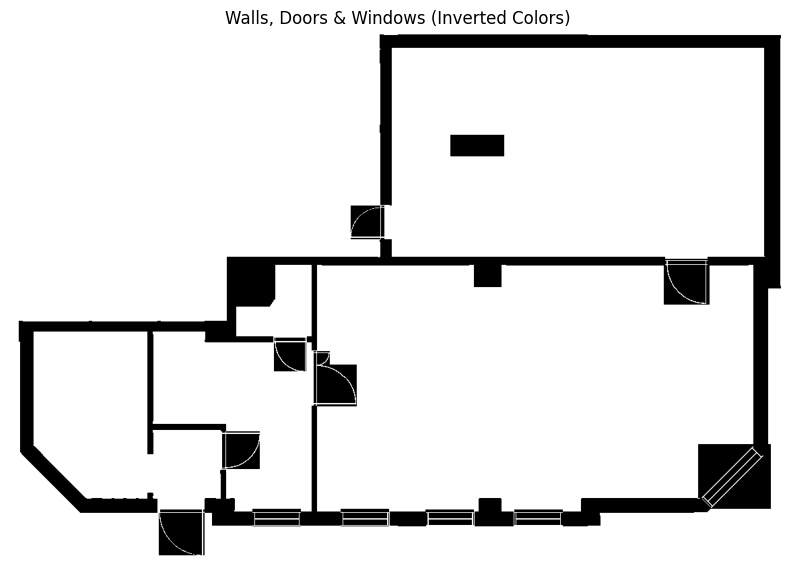

In [ ]:
# Invert the colors of the contour mask
inverted_mask = cv2.bitwise_not(combined_mask)

# Display the inverted output
plt.figure(figsize=(10, 10))
plt.imshow(inverted_mask, cmap='gray')
plt.title("Walls, Doors & Windows (Inverted Colors)")
plt.axis("off")
plt.show()

# SIFT

In [ ]:
sift = cv2.SIFT_create()  # Create SIFT feature detector and descriptor
bf = cv2.BFMatcher()  # Create a brute-force matcher for feature matching

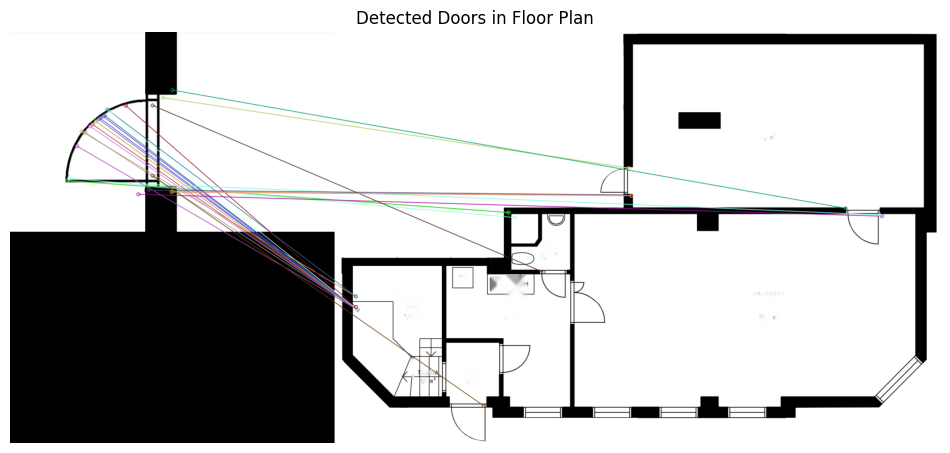

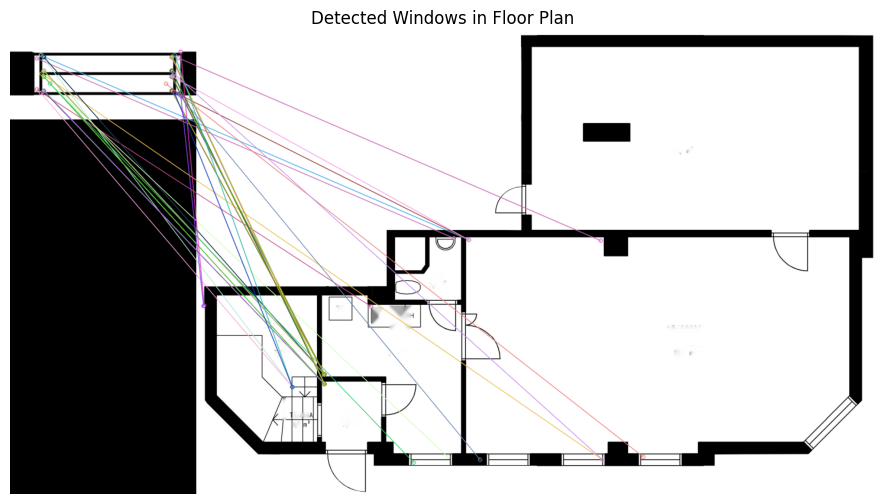

In [ ]:
# Load the floor plan and template images
floor_plan_path = "/content/floor_plan_no_text.png"
door_template_path = "/content/door3.png"  # First uploaded image (door)
window_template_path = "/content/window.png"  # Second uploaded image (window)

# Read images
floor_plan = cv2.imread(floor_plan_path, cv2.IMREAD_GRAYSCALE)
door_template = cv2.imread(door_template_path, cv2.IMREAD_GRAYSCALE)
window_template = cv2.imread(window_template_path, cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Compute key points and descriptors for door template
keypoints_door, descriptors_door = sift.detectAndCompute(door_template, None)

# Compute key points and descriptors for window template
keypoints_window, descriptors_window = sift.detectAndCompute(window_template, None)

# Compute key points and descriptors for the floor plan
keypoints_plan, descriptors_plan = sift.detectAndCompute(floor_plan, None)

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher()

# Match door template with the floor plan
matches_door = bf.knnMatch(descriptors_door, descriptors_plan, k=2)

# Match window template with the floor plan
matches_window = bf.knnMatch(descriptors_window, descriptors_plan, k=2)

# Apply ratio test to filter good matches (Lowe’s ratio test)
good_matches_door = [m for m, n in matches_door if m.distance < 0.85 * n.distance]
good_matches_window = [m for m, n in matches_window if m.distance < 1 * n.distance]

# Draw matches for visualization
matched_door_image = cv2.drawMatches(door_template, keypoints_door, floor_plan, keypoints_plan, good_matches_door, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
matched_window_image = cv2.drawMatches(window_template, keypoints_window, floor_plan, keypoints_plan, good_matches_window, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched results
plt.figure(figsize=(12, 6))
plt.imshow(matched_door_image, cmap='gray')
plt.title("Detected Doors in Floor Plan")
plt.axis("off")
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(matched_window_image, cmap='gray')
plt.title("Detected Windows in Floor Plan")
plt.axis("off")
plt.show()


# VECTORIZE

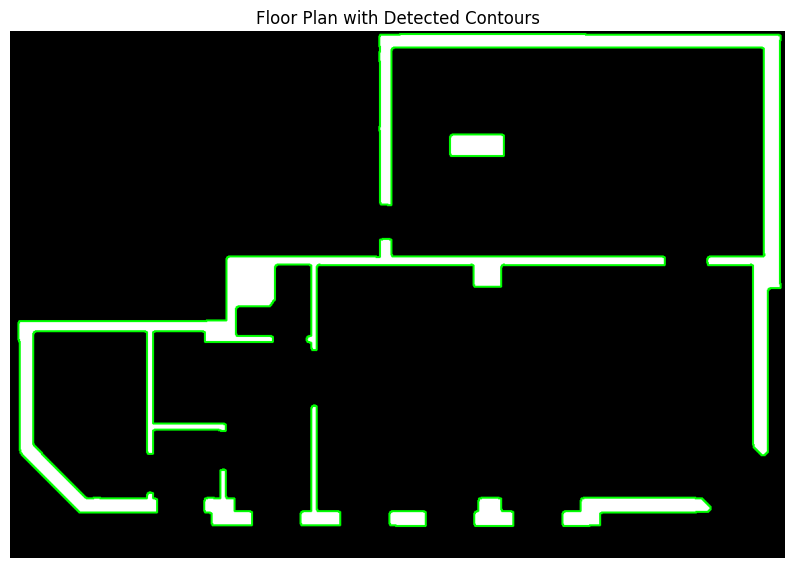

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/walls.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise IOError("Image not found")

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Use Canny edge detector to find edges in the image
edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

# Find contours from the edged image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR color image
cv2.drawContours(img_color, contours, -1, (0, 255, 0), 2)  # Draw contours with green lines

# Show the image with contours
plt.figure(figsize=(10, 15))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title('Floor Plan with Detected Contours')
plt.axis('off')
plt.show()

In [ ]:
!pip install svgwrite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 6.3 MB/s eta 0:00:00


Vectorized contour coordinates saved to: /content/vectorized_walls.json
SVG file saved at: /content/vectorized_walls.svg


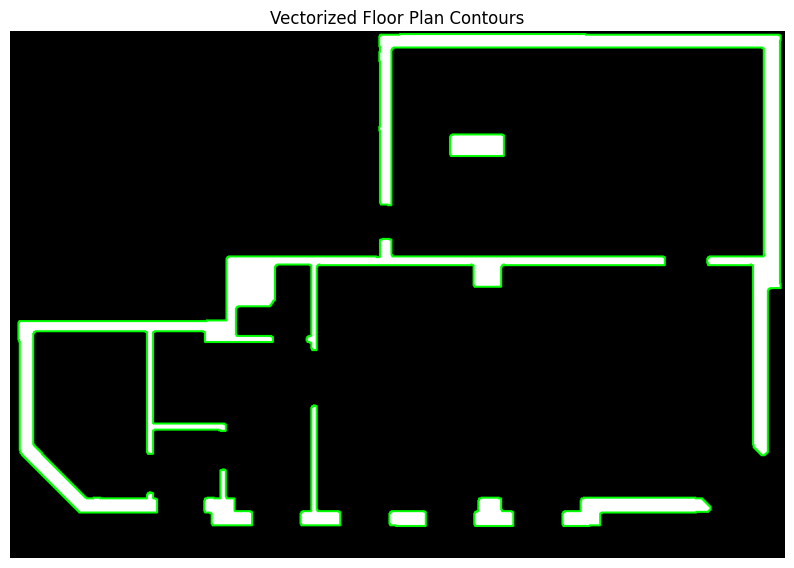

In [ ]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import svgwrite

# Load the image
image_path = "/content/walls.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise IOError("Image not found")

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Use Canny edge detector to find edges
edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store extracted contour data in JSON format
vectorized_contours = []

for contour in contours:
    if cv2.contourArea(contour) > 500:  # Ignore small artifacts
        points = [{"x": int(pt[0][0]), "y": int(pt[0][1])} for pt in contour]
        vectorized_contours.append(points)

# Save as JSON
json_path = "/content/vectorized_walls.json"
with open(json_path, "w") as f:
    json.dump(vectorized_contours, f, indent=4)

print(f"Vectorized contour coordinates saved to: {json_path}")

# ===================================== #
# **Save the vectorized contours as SVG**
# ===================================== #

# Get image dimensions
height, width = img.shape

# Create an SVG drawing
dwg = svgwrite.Drawing("/content/vectorized_walls.svg", size=(width, height))

# Draw each contour as a path in SVG
for contour in vectorized_contours:
    path_data = "M " + " L ".join(f"{pt['x']},{pt['y']}" for pt in contour) + " Z"
    dwg.add(dwg.path(d=path_data, stroke="black", fill="none", stroke_width=2))

# Save SVG file
dwg.save()
print("SVG file saved at: /content/vectorized_walls.svg")

# ===================================== #
# **Visualize the extracted contours**
# ===================================== #
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to BGR for visualization
cv2.drawContours(img_color, contours, -1, (0, 255, 0), 2)  # Draw contours in green

# Display the image with detected contours
plt.figure(figsize=(10, 15))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Vectorized Floor Plan Contours")
plt.axis("off")
plt.show()


# COORDINATES

Edge coordinates saved to: /content/edge_coordinates.json


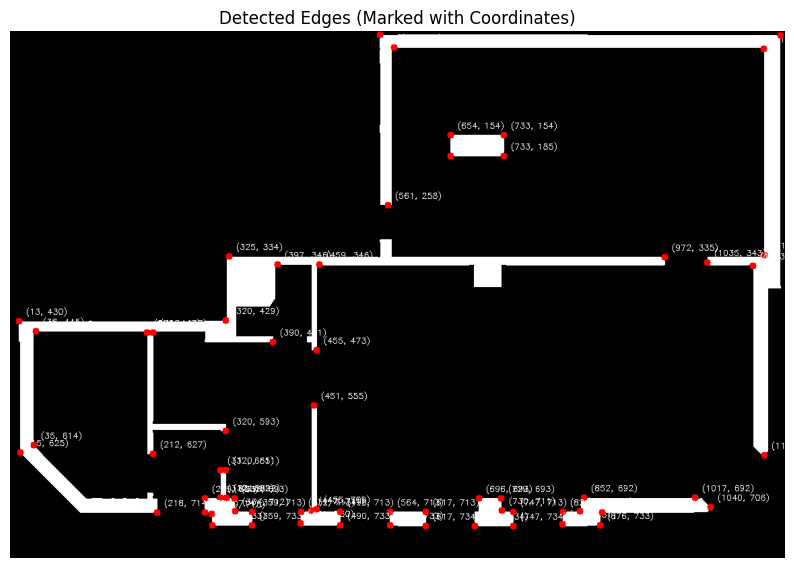

Marked edges image saved to: /content/marked_edges.png


In [ ]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/walls.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise IOError("Image not found")

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Use Canny edge detector to find edges
edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store edge coordinates
edge_coordinates = []

# Convert grayscale to color for visualization
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for contour in contours:
    if cv2.contourArea(contour) > 500:  # Ignore small artifacts
        # Approximate the contour to get only the corner points
        epsilon = 0.02 * cv2.arcLength(contour, True)  # Adjust epsilon for accuracy
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Store only the corner points (edges)
        edges_list = [{"x": int(pt[0][0]), "y": int(pt[0][1])} for pt in approx]
        edge_coordinates.append(edges_list)

        # Draw detected edges on the image
        for point in edges_list:
            x, y = point["x"], point["y"]
            cv2.circle(img_color, (x, y), 5, (0, 0, 255), -1)  # Draw red dot
            cv2.putText(img_color, f"({x}, {y})", (x + 10, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)  # Label coordinates

# Save edge coordinates as JSON
json_path = "/content/edge_coordinates.json"
with open(json_path, "w") as f:
    json.dump(edge_coordinates, f, indent=4)

print(f"Edge coordinates saved to: {json_path}")

# Save the result image with marked edges
marked_image_path = "/content/marked_edges.png"
cv2.imwrite(marked_image_path, img_color)

# Display the image with detected edge points
plt.figure(figsize=(10, 15))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Detected Edges (Marked with Coordinates)")
plt.axis("off")
plt.show()

print(f"Marked edges image saved to: {marked_image_path}")


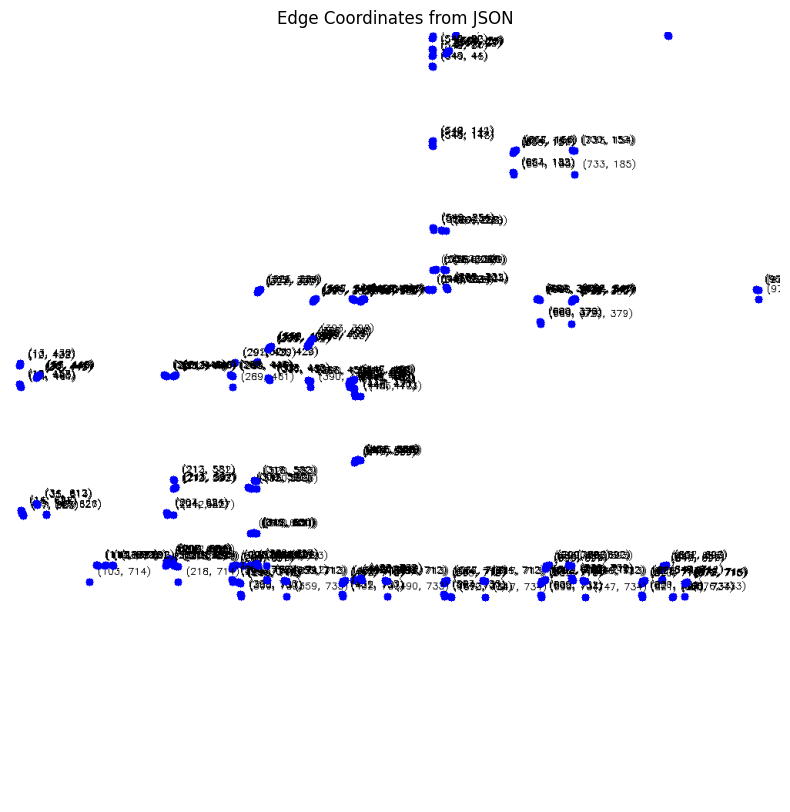

Edge-marked image saved at: /content/marked_edges_from_json.png


In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the vectorized wall data from JSON
json_path = "/content/vectorized_walls.json"

with open(json_path, "r") as f:
    wall_vectors = json.load(f)

# Create a blank image to visualize
img_size = (1000, 1000)  # Adjust based on SVG dimensions
img = np.ones((img_size[1], img_size[0], 3), dtype=np.uint8) * 255  # White canvas

# Convert JSON data to edge points and mark them
for contour in wall_vectors:
    for i, point in enumerate(contour):
        x, y = point["x"], point["y"]
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)  # Red dot for edges
        cv2.putText(img, f"({x}, {y})", (x + 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)  # Label coordinates

# Save and display the marked image
marked_image_path = "/content/marked_edges_from_json.png"
cv2.imwrite(marked_image_path, img)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Edge Coordinates from JSON")
plt.axis("off")
plt.show()

print(f"Edge-marked image saved at: {marked_image_path}")


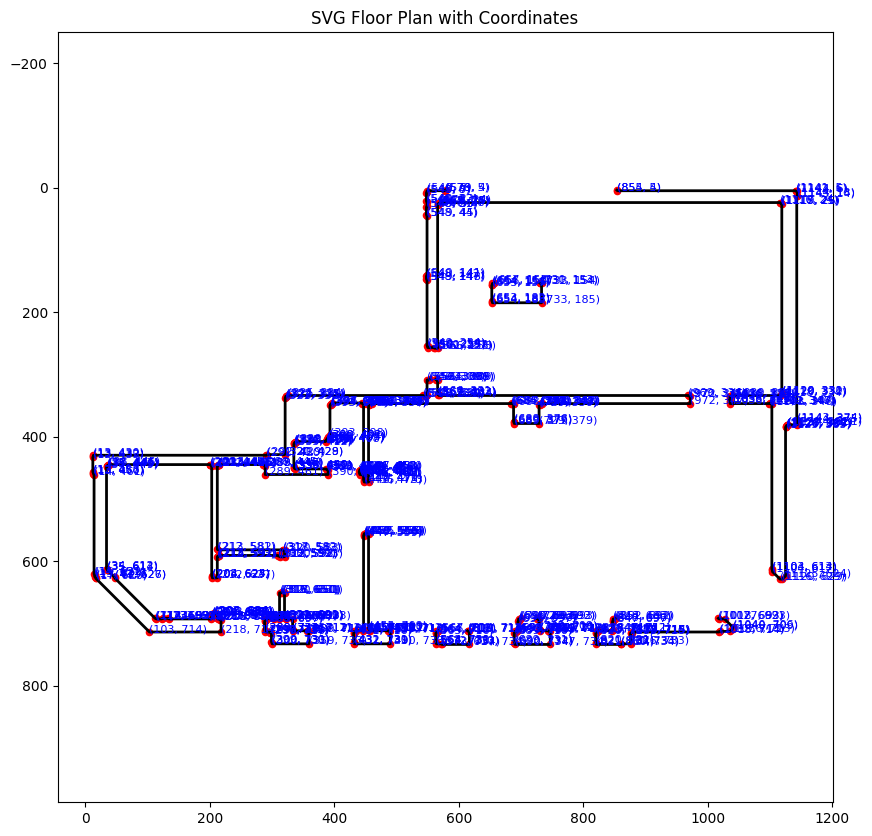

In [ ]:
import svgwrite
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Load the SVG file
svg_path = "/content/vectorized_walls.svg"

# Parse SVG and extract paths
tree = ET.parse(svg_path)
root = tree.getroot()

# Extract all path coordinates from SVG
svg_coordinates = []
for elem in root.iter("{http://www.w3.org/2000/svg}path"):
    d = elem.attrib["d"]  # Extract path data
    points = []

    for segment in d.split(" "):
        if "," in segment:
            x, y = segment.split(",")
            points.append((float(x), float(y)))

    if points:
        svg_coordinates.append(points)

# Plot the extracted points
plt.figure(figsize=(10, 10))

# Draw all paths
for contour in svg_coordinates:
    x_vals = [p[0] for p in contour]
    y_vals = [p[1] for p in contour]

    plt.plot(x_vals, y_vals, 'k-', linewidth=2)  # Black lines for walls
    plt.scatter(x_vals, y_vals, color='red', s=20)  # Red dots for edges

    # Label each point with coordinates
    for (x, y) in zip(x_vals, y_vals):
        plt.text(x, y, f"({int(x)}, {int(y)})", fontsize=8, color="blue")

# Display the final visualization
plt.title("SVG Floor Plan with Coordinates")
plt.gca().invert_yaxis()  # Flip y-axis to match SVG format
plt.axis("equal")
plt.show()


WINDOW AND DOOR LOCATION COORDINATES

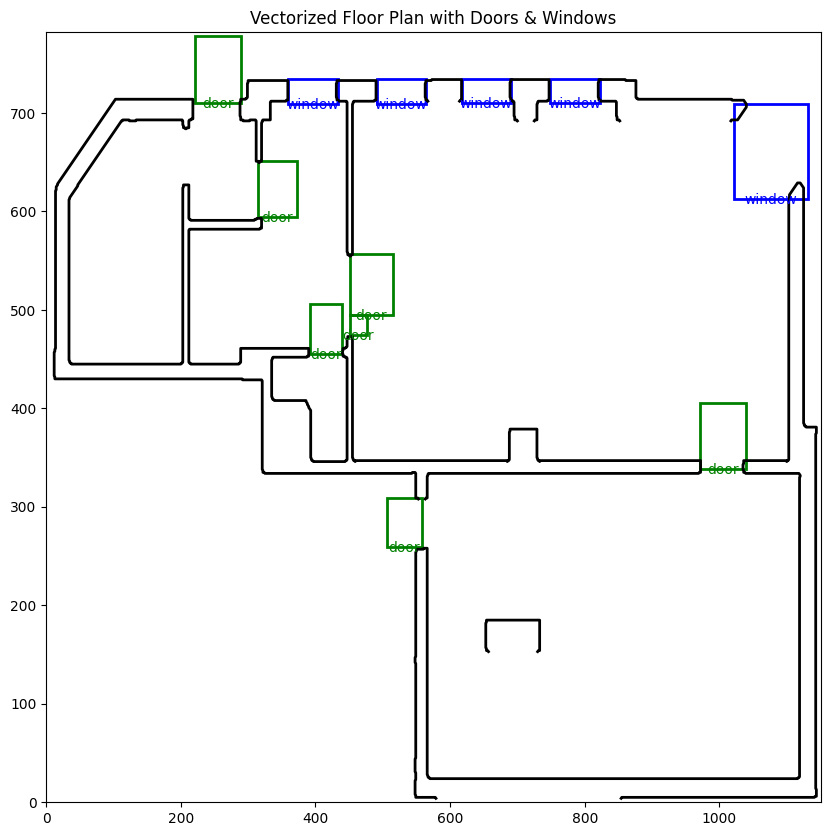

In [ ]:
import svgwrite
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

# Load the vectorized walls SVG
svg_path = "/content/vectorized_walls.svg"
output_path="/content/vectorized_walls_with_doors.svg"

# Load doors & windows JSON data
json_data = [
    {"x": 343, "y": 622, "width": 57, "height": 57, "class": "door"},
    {"x": 532, "y": 284, "width": 53, "height": 50, "class": "door"},
    {"x": 255, "y": 744, "width": 68, "height": 68, "class": "door"},
    {"x": 416, "y": 480, "width": 48, "height": 51, "class": "door"},
    {"x": 483, "y": 526, "width": 64, "height": 62, "class": "door"},
    {"x": 1005, "y": 372, "width": 68, "height": 68, "class": "door"},
    {"x": 463, "y": 485, "width": 25, "height": 20, "class": "door"},
    {"x": 396, "y": 722, "width": 73, "height": 26, "class": "window"},
    {"x": 527, "y": 722, "width": 73, "height": 26, "class": "window"},
    {"x": 1076, "y": 661, "width": 109, "height": 96, "class": "window"},
    {"x": 785, "y": 722, "width": 73, "height": 25, "class": "window"},
    {"x": 653, "y": 722, "width": 73, "height": 25, "class": "window"},
]

# Parse the existing SVG to get dimensions
tree = ET.parse(svg_path)
root = tree.getroot()
svg_width = int(root.attrib["width"])
svg_height = int(root.attrib["height"])

# Create a blank image for visualization
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, svg_width)
ax.set_ylim(svg_height, 0)  # Invert y-axis to match SVG coordinates

# Plot the existing walls from SVG paths
for elem in root.iter("{http://www.w3.org/2000/svg}path"):
    path_data = elem.attrib["d"]
    points = []
    for segment in path_data.split(" "):
        if "," in segment:
            x, y = segment.split(",")
            points.append((float(x), float(y)))
    if points:
        points = np.array(points)
        ax.plot(points[:, 0], points[:, 1], 'k-', linewidth=2)  # Black walls

# Overlay bounding boxes for doors & windows
for obj in json_data:
    x, y, w, h = obj["x"], obj["y"], obj["width"], obj["height"]
    label = obj["class"]
    color = "green" if label == "door" else "blue"  # Green for doors, blue for windows

    # Draw bounding box
    rect = plt.Rectangle((x - w // 2, y - h // 2), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    # Add label
    ax.text(x, y - h // 2 - 5, label, fontsize=10, color=color, ha="center")

# Display the visualization
ax.set_title("Vectorized Floor Plan with Doors & Windows")
plt.gca().invert_yaxis()  # Match SVG coordinate system
plt.show()


In [ ]:

# Save the figure
fig.savefig(output_path, bbox_inches='tight', dpi=300)

# Save the updated SVG with doors & windows
dwg = svgwrite.Drawing("/content/vectorized_walls_with_doors.svg", size=(svg_width, svg_height))

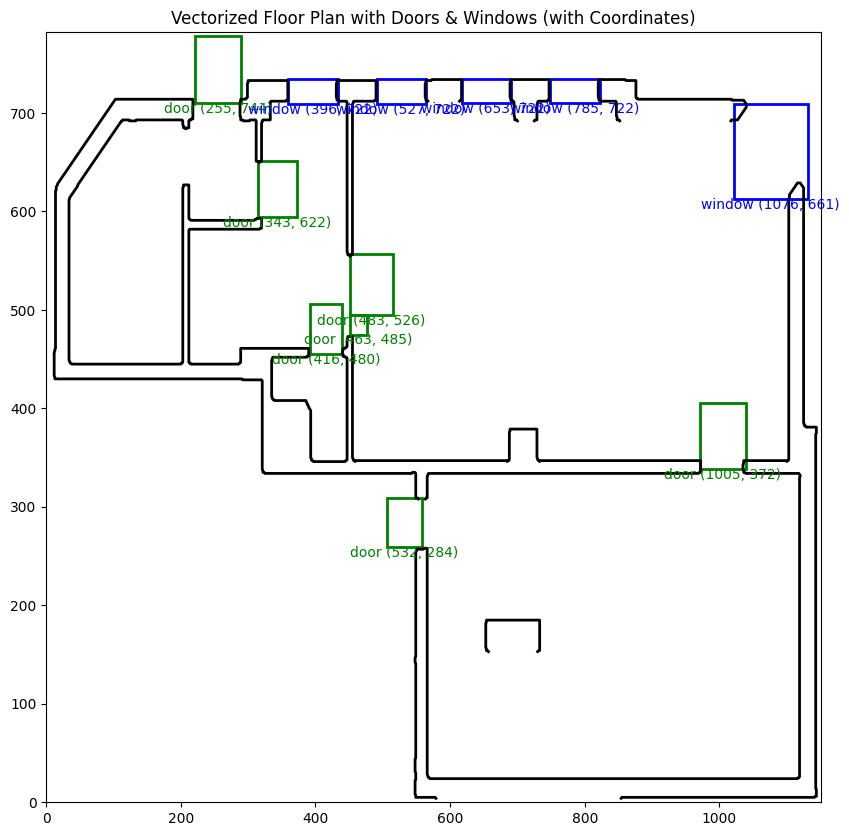

In [ ]:
# Re-import necessary libraries after execution reset
import svgwrite
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

# Reload JSON Data for doors and windows
json_data = [
    {"x": 343, "y": 622, "width": 57, "height": 57, "class": "door"},
    {"x": 532, "y": 284, "width": 53, "height": 50, "class": "door"},
    {"x": 255, "y": 744, "width": 68, "height": 68, "class": "door"},
    {"x": 416, "y": 480, "width": 48, "height": 51, "class": "door"},
    {"x": 483, "y": 526, "width": 64, "height": 62, "class": "door"},
    {"x": 1005, "y": 372, "width": 68, "height": 68, "class": "door"},
    {"x": 463, "y": 485, "width": 25, "height": 20, "class": "door"},
    {"x": 396, "y": 722, "width": 73, "height": 26, "class": "window"},
    {"x": 527, "y": 722, "width": 73, "height": 26, "class": "window"},
    {"x": 1076, "y": 661, "width": 109, "height": 96, "class": "window"},
    {"x": 785, "y": 722, "width": 73, "height": 25, "class": "window"},
    {"x": 653, "y": 722, "width": 73, "height": 25, "class": "window"},
]

# Reload the vectorized walls SVG
svg_path = "/content/vectorized_walls.svg"

# Parse the existing SVG to get dimensions
tree = ET.parse(svg_path)
root = tree.getroot()
svg_width = int(root.attrib["width"])
svg_height = int(root.attrib["height"])

# Create a blank image for visualization
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, svg_width)
ax.set_ylim(svg_height, 0)  # Invert y-axis to match SVG coordinates

# Plot the existing walls from SVG paths
for elem in root.iter("{http://www.w3.org/2000/svg}path"):
    path_data = elem.attrib["d"]
    points = []
    for segment in path_data.split(" "):
        if "," in segment:
            x, y = segment.split(",")
            points.append((float(x), float(y)))
    if points:
        points = np.array(points)
        ax.plot(points[:, 0], points[:, 1], 'k-', linewidth=2)  # Black walls

# Overlay bounding boxes and coordinates for doors & windows
for obj in json_data:
    x, y, w, h = obj["x"], obj["y"], obj["width"], obj["height"]
    label = obj["class"]
    color = "green" if label == "door" else "blue"  # Green for doors, blue for windows

    # Draw bounding box
    rect = plt.Rectangle((x - w // 2, y - h // 2), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    # Add label and coordinates
    ax.text(x, y - h // 2 - 10, f"{label} ({x}, {y})", fontsize=10, color=color, ha="center")

# Display the visualization
ax.set_title("Vectorized Floor Plan with Doors & Windows (with Coordinates)")
plt.gca().invert_yaxis()  # Match SVG coordinate system
plt.show()


# ALL COORDINATES

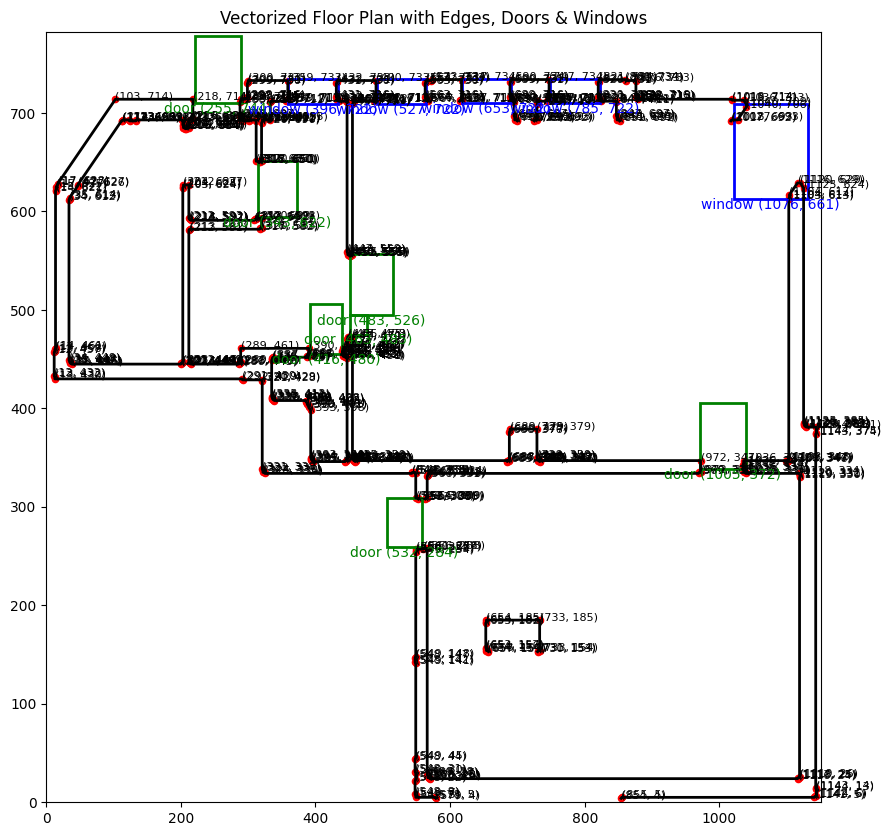

In [ ]:
# Create a new figure to visualize edges along with doors & windows
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, svg_width)
ax.set_ylim(svg_height, 0)  # Invert y-axis to match SVG coordinates

# Plot the existing walls from SVG paths
for elem in root.iter("{http://www.w3.org/2000/svg}path"):
    path_data = elem.attrib["d"]
    points = []
    for segment in path_data.split(" "):
        if "," in segment:
            x, y = segment.split(",")
            points.append((float(x), float(y)))
    if points:
        points = np.array(points)
        ax.plot(points[:, 0], points[:, 1], 'k-', linewidth=2)  # Black walls

# Extract edges from walls
edge_coordinates = []
for elem in root.iter("{http://www.w3.org/2000/svg}path"):
    path_data = elem.attrib["d"]
    points = []
    for segment in path_data.split(" "):
        if "," in segment:
            x, y = segment.split(",")
            points.append((float(x), float(y)))
    if points:
        for pt in points:
            edge_coordinates.append((int(pt[0]), int(pt[1])))
            ax.scatter(pt[0], pt[1], color="red", s=20)  # Red dots for edges
            ax.text(pt[0], pt[1], f"({int(pt[0])}, {int(pt[1])})", fontsize=8, color="black")

# Overlay bounding boxes and coordinates for doors & windows
for obj in json_data:
    x, y, w, h = obj["x"], obj["y"], obj["width"], obj["height"]
    label = obj["class"]
    color = "green" if label == "door" else "blue"  # Green for doors, blue for windows

    # Draw bounding box
    rect = plt.Rectangle((x - w // 2, y - h // 2), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    # Add label and coordinates
    ax.text(x, y - h // 2 - 10, f"{label} ({x}, {y})", fontsize=10, color=color, ha="center")

# Display the visualization
ax.set_title("Vectorized Floor Plan with Edges, Doors & Windows")
plt.gca().invert_yaxis()  # Match SVG coordinate system
plt.show()


In [ ]:
# Save the visualization as a PNG file
output_png_path = "/content/vectorized_walls_with_edges_doors_windows.png"
fig.savefig(output_png_path, bbox_inches='tight', dpi=300)

# Save the updated SVG with walls, edges, doors & windows
output_svg_path = "/content/vectorized_walls_with_edges_doors_windows.svg"
dwg = svgwrite.Drawing(output_svg_path, size=(svg_width, svg_height))

# Copy existing walls to new SVG
for elem in root.iter("{http://www.w3.org/2000/svg}path"):
    dwg.add(dwg.path(d=elem.attrib["d"], stroke="black", fill="none", stroke_width=2))

# Add edges as red dots
for x, y in edge_coordinates:
    dwg.add(dwg.circle(center=(x, y), r=3, fill="red"))

# Add doors & windows bounding boxes
for obj in json_data:
    x, y, w, h = obj["x"], obj["y"], obj["width"], obj["height"]
    label = obj["class"]
    color = "green" if label == "door" else "blue"  # Green for doors, blue for windows

    # Draw bounding box in SVG
    dwg.add(dwg.rect(
        insert=(x - w // 2, y - h // 2),
        size=(w, h),
        stroke=color,
        fill="none",
        stroke_width=2
    ))

    # Add label text with coordinates
    dwg.add(dwg.text(f"{label} ({x}, {y})", insert=(x, y - h // 2 - 5), fill=color, font_size="12px"))

# Save the updated SVG
dwg.save()

output_png_path, output_svg_path


('/content/vectorized_walls_with_edges_doors_windows.png',
 '/content/vectorized_walls_with_edges_doors_windows.svg')

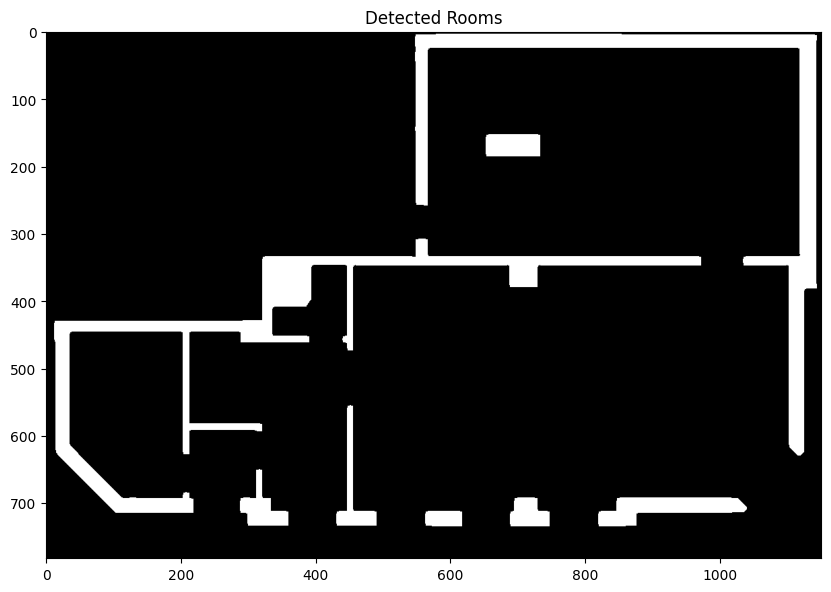

('/content/vectorized_rooms.svg', '/content/detected_rooms.json')

In [ ]:
import svgwrite
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

# Load the uploaded SVG file
svg_path = "/content/final_vectorized_floor_plan.svg"
output_svg_path = "/content/vectorized_rooms.svg"
output_json_path = "/content/detected_rooms.json"

# Parse the SVG file
tree = ET.parse(svg_path)
root = tree.getroot()

# Get SVG dimensions
svg_width = int(root.attrib["width"])
svg_height = int(root.attrib["height"])

# Create a blank image for room detection
room_mask = np.zeros((svg_height, svg_width), dtype=np.uint8)

# Extract room contours from SVG paths
room_contours = []
for elem in root.iter("{http://www.w3.org/2000/svg}path"):
    path_data = elem.attrib["d"]
    points = []
    for segment in path_data.split(" "):
        if "," in segment:
            x, y = segment.split(",")
            points.append((float(x), float(y)))
    if points:
        points = np.array(points, dtype=np.int32)
        room_contours.append(points)
        cv2.fillPoly(room_mask, [points], 255)  # Fill detected rooms

# Detect separate enclosed areas (rooms)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(room_mask)

# Store detected rooms
rooms_data = []
dwg = svgwrite.Drawing(output_svg_path, size=(svg_width, svg_height))

# Assign colors for different rooms
room_colors = [
    "red", "blue", "green", "yellow", "purple", "orange", "cyan", "magenta"
]

# Draw detected rooms and label them
for i in range(1, num_labels):  # Skip background (label 0)
    x, y, w, h, area = stats[i]
    room_name = f"Room {i}"
    color = room_colors[i % len(room_colors)]

    # Save room data in JSON format
    rooms_data.append({
        "name": room_name,
        "bounding_box": [int(x), int(y), int(w), int(h)],  # Convert to Python int
        "centroid": [int(centroids[i][0]), int(centroids[i][1])]  # Convert to Python int
    })

    # Draw bounding box for the room
    dwg.add(dwg.rect(
        insert=(int(x), int(y)), size=(int(w), int(h)), stroke=color, fill="none", stroke_width=2
    ))

    # Label the room in the SVG
    dwg.add(dwg.text(room_name, insert=(x + w // 2, y + h // 2),
                      fill=color, font_size="12px", text_anchor="middle"))

# Save JSON with room data
with open(output_json_path, "w") as json_file:
    json.dump(rooms_data, json_file, indent=4)

# Save the updated SVG with room labels
dwg.save()

# Display the detected rooms
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(room_mask, cmap="gray")
ax.set_title("Detected Rooms")
plt.show()

output_svg_path, output_json_path
